# Final Project: An Analysis of the Relationship Between Product Review Star Ratings and Comments
### Name: Samantha Cohen 
### Uniqname: samcoh
### Class: SI 330 

### Main Question: ”What is the Relationship between Electronic Product Review Star Ratings and Comment Rating Reviews?” 



## 1. Import Data Needed

In [1]:
import pandas as pd
import requests
import json
import numpy as np
import altair as alt
from altair.expr import datum

# Part 1: Put the CSV file into a Pandas DataFrame and Filter/Manipulate Columns

## 1. Open the CSV file with Electronic Product Review Information and create a Pandas DataFrame 

In [2]:
df = pd.read_csv('DatafinitiElectronicsProductData.csv')


## 2. Create a new Pandas DataFrame with just the columns you want
#### Columns: id, name, brand, dateAdded, reviews.username, reviews.rating, reviews.text, sourceURLs 

In [3]:
new_df = df[["id","name","brand","dateAdded","reviews.username","reviews.rating","reviews.text","sourceURLs"]]


## 3. Rename the Columns in the new Pandas DataFrame

In [4]:
new_df.columns = ["id","product","brand","review_date_added","username","review_rating","review_text","sourceURLs"]


#### Columns should now be called: id, product, brand, review_date_added, username, review_rating, review_text, sourceURLs

# Part 2: Get Sentiment Analysis Data for the review_text column in the Pandas Dataframe using the Datumbox API, and store responses into a cache file. 

## 1. Get a token from the Datumbox API 

In [5]:
API = "8992c5d504360f35453252f4de762eab"

## 2. Cache the Sentiment Analysis Data 

#### The cache file should be json formatted. The cache file will store a dictionary where the keys are the index and the values are the response from the Datumbox API 

### a) Try and Except Statement: Try opening the cache file, but if it doesn't exist than create an empty dictionary. 

In [6]:
CACHE_FNAME = 'cache_analysis_2.json'
try:
    cache_file = open(CACHE_FNAME, 'r')
    cache_contents = cache_file.read()
    CACHE_DICTION = json.loads(cache_contents)
    cache_file.close()
except:
    CACHE_DICTION = {}


### b) make a request using cache. 
#### create a function make_request_using_cache: The purpose of this function is to get response data from the cache file if it is there or the call the Datumbox API if it is not there. If the data is not in the cache file it should add it. 
#### parameters: baseurl, params, and the index of the the text comment (review_text) in the Pandas DataFrame
#### return: the response from the Datumbox API (either from the cache file or call the API) 

In [7]:
def make_request_using_cache(baseurl, params, index):
    unique_ident = index

    if str(unique_ident) in CACHE_DICTION:
        return CACHE_DICTION[str(unique_ident)]
    else:
        response = requests.post(baseurl, data = params)
        resp = json.loads(response.text)
        if resp["output"]["status"] == 1:
            CACHE_DICTION[unique_ident] = resp

            dumped_json_cache = json.dumps(CACHE_DICTION)
            fw = open(CACHE_FNAME,"w")
            fw.write(dumped_json_cache)
            fw.close()
            return CACHE_DICTION[unique_ident]
        else:
            return resp

### c) Create a function that will make the params dictionary (for the requests.post), get the url, and use the index (of review_text from the Pandas DataFrame) to call make_request_using_caching 
#### create a function get_datumbox_caching that will create the url and params dictionary. The function will then call the function make_request_using_cache. 
#### parameters: comment (review_text) and index (the index of the review_text from the pandas DataFrame). 
#### return: the response from the Datumbox API 


In [8]:
def get_datumbox_caching(comment, index):
    baseurl = "http://api.datumbox.com:80/1.0/SentimentAnalysis.json"
    params_diction = {"api_key": "8992c5d504360f35453252f4de762eab", "text":comment}
    return make_request_using_cache(baseurl, params_diction, index)



## 3. Create api_call function that will call get_datumbox_caching function which will get data from the API or the Cache

#### api_call function: will call the get_datumbox_caching function. The purpose of this function is to stop calling the Datumbox API if it returns an error for a particular review_text 

#### parameters: a dictionary where the keys are the index from the pandas dataframe and the values are the review_text associated with that index 

#### returns: if it runs successfully it will return the string "ran" to indicate the job has completed successfully. If it does not run successfully, it will return the error dictionary returned from Datumbox 

In [9]:
def api_call(dic):
    for i in dic:
        index = i
        text = dic[i]
        response = get_datumbox_caching(text, index)
        if response["output"]["status"] == 1:
            continue
        else:
            return response["output"]["error"]
    return "ran"

## 4. Datumbox API has a limit of 1000 calls per/day. In this step Create functions that you can call to get the sentiment analysis from the last review_text left off at. 

#### You will call these functions until you get all review_text sentiment analysis
#### function last_index_gotten: The purpose of this function is to see the last review_text left off at. It does not take in any parameters and will return the last index in the cache file. If the cache file is empty (has not been created) call the index of 0 
#### function get_1000_rows: the purpose of this function is to get the next 1000 review_text. The function form of a dictionary (keys = index, values = review_text). Then it will call the function api_call with this dictionary. The parameter of this function is an integer that indicates the last index left off at from the cache file. This function does not return anything, but it prints ran, if the api_call ran successfully, or error, if the api_call did not run succesfully. 

In [10]:
def get_1000_rows(last_ind_left_off_at):
    index_text_tup = list(zip(new_df.index, new_df["review_text"]))
    if index_text_tup[-1][0] == last_ind_left_off_at: 
        return "json file has all the sentiment analysis data"
    if index_text_tup[-1][0] - last_ind_left_off_at < 1000: 
        start = last_ind_left_off_at + 1
        dict_index_text_tup = dict(index_text_tup[start:])
        print(api_call(dict_index_text_tup))
    else: 
        start = last_ind_left_off_at + 1
        end = start + 1000
        if last_ind_left_off_at == 0:
            dict_index_text_tup = dict(index_text_tup[:end-1])
            print(api_call(dict_index_text_tup))
        else: 
            dict_index_text_tup = dict(index_text_tup[start:end])
            print(api_call(dict_index_text_tup))

def last_index_gotten():
    try: 
        file = open("cache_analysis_2.json", "r")
        dic =json.loads(file.read())
        last_ind_left_off_at = sorted(list(dic.keys()), key= lambda x: int(x))[-1]
        #print(last_ind_left_off_at)
        file.close()
        return int(last_ind_left_off_at)
    except: 
        return 0 



## 5. Call the functions last_index_gotten and get_1000_rows to create the cache file. 
#### Run this line of Code everyday until you receive the string that says 'json file has all the sentiment analysis data' (should run for 8 days).

In [11]:
index = last_index_gotten()
get_1000_rows(index)


'json file has all the sentiment analysis data'

# Part 3: Combine Data Sources - Once you have all the sentiment analysis data in the cache file, you should put this data in the pandas DataFrame. 

## 1. Open the cache file and get the data 

In [12]:
file = open("cache_analysis_2.json", "r")
responses  = json.loads(file.read())
file.close() 



## 2. Create a list of all the responses for each index in order. 

In [13]:
evaluations = [responses[x]["output"]["result"] for x in responses]

## 3. Create a new column in the pandas DataFrame with the DatumBox analysis responses (which is now a list called evaluations) 

In [14]:
new_df = new_df.assign(Datumbox_Score = evaluations)

# Part 4: Create Visualization to use for Analysis 

## 1. Create a new pandas DataFrame called graphing. Use new_df and groupby "review_rating" and "Datumbox_Score". Also include a count for each row. 


In [15]:
graphing = new_df.groupby(["review_rating","Datumbox_Score"]).size().reset_index(name = "counts") #[reset+index numbers turn into last columm]
graphing

#cross tabulation 
#grouping by two variables taking count of instances of each in each unique combination 


,review_rating,Datumbox_Score,counts
0,1.0,negative,289
1,1.0,neutral,2
2,1.0,positive,27
3,2.0,negative,169
4,2.0,neutral,2
5,2.0,positive,51
6,3.0,negative,240
7,3.0,neutral,4
8,3.0,positive,196
9,4.0,negative,308


## a) Create a heatmap where your normalize by review_rating (row) 

### 1. Create a new column in graphing that shows the sum of the counts for each group in review_rating. 

In [16]:
#get the sum of the counts for each group in review_rating 
sums = graphing.groupby("review_rating").sum()


#created a dictionary using pandas 
d= sums.to_dict(orient='dict')


##print(d)
##print(d["counts"][1.0]) 

#create a sum column in the graphing pandas dataframe called Sum_of_Counts
#Initally, make the values in this column the same values in review_rating 
graphing["Sum_of_Counts"] = graphing["review_rating"]

#Use .replace to replace the values in Sum_of_Counts
#Replace these values with the true sum of counts located in the dictionary created above, called d. 
graphing["Sum_of_Counts"] = graphing["Sum_of_Counts"].replace(1.0,d["counts"][1.0])
graphing["Sum_of_Counts"] = graphing["Sum_of_Counts"].replace(2.0,d["counts"][2.0])
graphing["Sum_of_Counts"] = graphing["Sum_of_Counts"].replace(3.0,d["counts"][3.0])
graphing["Sum_of_Counts"] = graphing["Sum_of_Counts"].replace(4.0,d["counts"][4.0])
graphing["Sum_of_Counts"] = graphing["Sum_of_Counts"].replace(5.0,d["counts"][5.0])


graphing



,review_rating,Datumbox_Score,counts,Sum_of_Counts
0,1.0,negative,289,318.0
1,1.0,neutral,2,318.0
2,1.0,positive,27,318.0
3,2.0,negative,169,222.0
4,2.0,neutral,2,222.0
5,2.0,positive,51,222.0
6,3.0,negative,240,440.0
7,3.0,neutral,4,440.0
8,3.0,positive,196,440.0
9,4.0,negative,308,1663.0


### 2. Create a new column in graphing that shows a percentage for each row. This percentage is calculated for each row in each review_rating group. The percentage is calculated by doing (counts for that row)/(sum of counts for that review_rating group) 

In [17]:
Sum_of_Counts = graphing["Sum_of_Counts"].values
review_rating = graphing["review_rating"].values
counts = graphing["counts"].values

#assign variable percentages to the array counts/Sum_of_Counts 
percentages = counts/Sum_of_Counts

#Create an empty list called percentages_rounded
percentages_rounded = []

#Loop through each element in the array percentages 
#round each percentage 3 decimal places and multipy by 100 to get a percentage 
#append the result to the list percentages_rounded 
for num in percentages: 
    percentages_rounded.append(round(num,3)*100)

#Create a new column in graphing called Percentage with all the percentages in percentages_rounded 
graphing["Percentage"] = percentages_rounded
graphing



,review_rating,Datumbox_Score,counts,Sum_of_Counts,Percentage
0,1.0,negative,289,318.0,90.9
1,1.0,neutral,2,318.0,0.6
2,1.0,positive,27,318.0,8.5
3,2.0,negative,169,222.0,76.1
4,2.0,neutral,2,222.0,0.9
5,2.0,positive,51,222.0,23.0
6,3.0,negative,240,440.0,54.5
7,3.0,neutral,4,440.0,0.9
8,3.0,positive,196,440.0,44.5
9,4.0,negative,308,1663.0,18.5


### 3. Create Heatmap Visualization using Altair

First chart assigned to the variable heatmap 
1.	X axis is the Datumbox_Score from the pandas DataFrame graphing (type is nominal data) 
2.	Y axis is review_rating from the pandas DataFrame graphing (type is ordinal data) 
3.	Use the Percentage column from the pandas DataFrame graphing  for the color. The color shown on the heatmap is based on how high or low the percentage is (the higher the percentage the darker the color—highest is dark red and the lowest is a super light orange) 

Second Chart assigned to the variable text 
1.	X axis is the Datumbox_Score from the pandas DataFrame graphing (type is nominal data) 
2.	Y axis is review_rating from the pandas DataFrame graphing (type is ordinal data)
3.	The color of the text is changed depending on the Percentage column from the pandas DataFrame graphing (type of data is quantitative) so it is easily readable. If the percentage score is over 70 percent the color is white, else the color of the text is black

Lastly, Concatenate these two charts together so the percentage is shown (heatmap + text) 

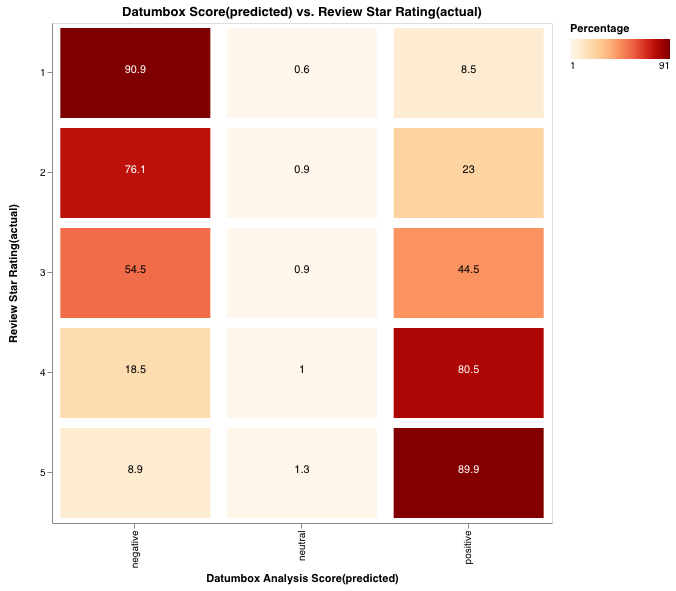

In [18]:
heatmap = alt.Chart(graphing).mark_rect().encode(
    alt.X('Datumbox_Score', type= "nominal", title = "Datumbox Analysis Score(predicted)"), 
    alt.Y('review_rating', type ='ordinal', title = "Review Star Rating(actual)"),
    alt.Color('Percentage',type='quantitative',scale=alt.Scale(scheme='orangered'))
    
).properties(title = "Datumbox Score(predicted) vs. Review Star Rating(actual)", width=500, height=500)
#heatmap

text = alt.Chart(graphing).mark_text().encode(
    alt.X('Datumbox_Score', type= "nominal", title = "Datumbox Analysis Score(predicted)"), 
    alt.Y('review_rating', type ='ordinal', title = "Review Star Rating(actual)"),
    text = 'Percentage',
    color = alt.condition(datum['Percentage'] > 70,
                          alt.value('white'),
                         alt.value('black'))
)

heatmap+text



In [19]:
#normalizing within rows: easy to predict score to predict sentiment 
#percentage within rating 
#second heatmap percentage within sentiment 

#when its review score of 1 its __ percent negative 
#use rating to predict sentiment (strongly correlated); given this particular rating can have a good guess of sentiment
#not skewed by counts 

##WORKS BEST FOR EXTREME but not so well for neutral. 
#The middle group should be dense here but its not
#Meanings the API ambiguous when it encounters neutral category (almost nothing)
#might think dense at netural 

#within ones most negative 
#normalizing within row 

#neutraal column barely every used 
#90 ish percent gave 1 star rating were rated as negative sentiment 
#this is what i would expect
#strong relationship between 
#in the middle they are split 50/50 so in the middle

#You cant predict neutral category on datumbox never used could use to predict if someone has a positive or negative score
#


## b) Create a heatmap where your normalize by Datumbox_Score (column) 

### 1. Create a new column in graphing that shows the sum of the counts for each group in Datumbox_Score. 

In [20]:
#get the sum of the counts for each group in Datumbox_Score 
sums_2 = graphing.groupby("Datumbox_Score").sum()


#created a dictionary using pandas 
d2 = sums_2.to_dict(orient='dict')


##print(d)
##print(d["counts"][1.0]) 

#create a sum column in the graphing pandas dataframe 
#Name this column Sum_of_Counts_Datumbox_Score
#Initially, make the values in this column the same values in Datumbox_Score. 
graphing["Sum_of_Counts_Datumbox_Score"] = graphing["Datumbox_Score"]


#Use .replace to replace the values in Sum_of_Counts_Datumbox_Score.
#Replace these values with the true sum of counts located in the dictionary created above, called d2. 
#The sum of counts for each Datumbox_Score are nested: d[“counts”][insert Datumbox Score str (positive, negative, or neutral)] 
graphing["Sum_of_Counts_Datumbox_Score"] = graphing["Sum_of_Counts_Datumbox_Score"].replace("positive",d2["counts"]["positive"])
graphing["Sum_of_Counts_Datumbox_Score"] = graphing["Sum_of_Counts_Datumbox_Score"].replace("negative",d2["counts"]["negative"])
graphing["Sum_of_Counts_Datumbox_Score"] = graphing["Sum_of_Counts_Datumbox_Score"].replace("neutral",d2["counts"]["neutral"])



graphing



,review_rating,Datumbox_Score,counts,Sum_of_Counts,Percentage,Sum_of_Counts_Datumbox_Score
0,1.0,negative,289,318.0,90.9,1404
1,1.0,neutral,2,318.0,0.6,81
2,1.0,positive,27,318.0,8.5,5650
3,2.0,negative,169,222.0,76.1,1404
4,2.0,neutral,2,222.0,0.9,81
5,2.0,positive,51,222.0,23.0,5650
6,3.0,negative,240,440.0,54.5,1404
7,3.0,neutral,4,440.0,0.9,81
8,3.0,positive,196,440.0,44.5,5650
9,4.0,negative,308,1663.0,18.5,1404


### 2. Create a new column in graphing that shows a percentage for each row. This percentage is calculated for each row in each Datumbox_Score group. The percentage is calculated by doing (counts for that row)/(sum of counts for that Datumbox_Score group) 

In [21]:
Sum_of_Counts_datumbox = graphing["Sum_of_Counts_Datumbox_Score"].values
datumbox_score = graphing["Datumbox_Score"].values
counts = graphing["counts"].values

#Assign variable percentages to the array counts/Sum_of_Counts_Datumbox_Score
percentages = counts/Sum_of_Counts_datumbox

#Create an empty list called percentages_rounded. 
percentages_rounded = []

#Loop through array percentages and round each decimal 3 decimal places, multiply by 100 (to get a percentage)
#append each result to the list percentages_rounded. 
for num in percentages: 
    percentages_rounded.append(round(num,3)*100) 
    
#Create a new column in graphing called Percentage_Datumbox_Score with all the percentages in percentages_rounded 
graphing["Percentage_Datumbox_Score"] = percentages_rounded
graphing

#print(graphing.groupby("Datumbox_Score")["Percentage_Datumbox_Score"].sum())

,review_rating,Datumbox_Score,counts,Sum_of_Counts,Percentage,Sum_of_Counts_Datumbox_Score,Percentage_Datumbox_Score
0,1.0,negative,289,318.0,90.9,1404,20.6
1,1.0,neutral,2,318.0,0.6,81,2.5
2,1.0,positive,27,318.0,8.5,5650,0.5
3,2.0,negative,169,222.0,76.1,1404,12.0
4,2.0,neutral,2,222.0,0.9,81,2.5
5,2.0,positive,51,222.0,23.0,5650,0.9
6,3.0,negative,240,440.0,54.5,1404,17.1
7,3.0,neutral,4,440.0,0.9,81,4.9
8,3.0,positive,196,440.0,44.5,5650,3.5
9,4.0,negative,308,1663.0,18.5,1404,21.9


### 3. Create Heatmap Visualization using Altair

First chart assigned to the variable heatmap 
1.	X axis is the Datumbox_Score from the pandas DataFrame graphing (type is nominal data) 
2.	Y axis is review_rating from the pandas DataFrame graphing (type is ordinal data) 
3.	Use the Percentage_Datumbox_Score column from the pandas DataFrame graphing  for the color. The color shown on the heatmap is based on how high or low the percentage is (the higher the percentage the darker the color— highest is dark red and the lowest is a super light orange) 

Second Chart assigned to the variable text 
1.	X axis is the Datumbox_Score from the pandas DataFrame graphing (type is nominal data) 
2.	Y axis is review_rating from the pandas DataFrame graphing (type is ordinal data)
3.	The color of the text is changed depending on the Percentage_Datumbox_Score column from the pandas DataFrame graphing (type of data is quantitative) so it is easily readable. If the percentage score is over 30 percent the color is white, else the color of the text is black

Lastly, Concatenate these two charts together so the percentage is shown (heatmap + text) 

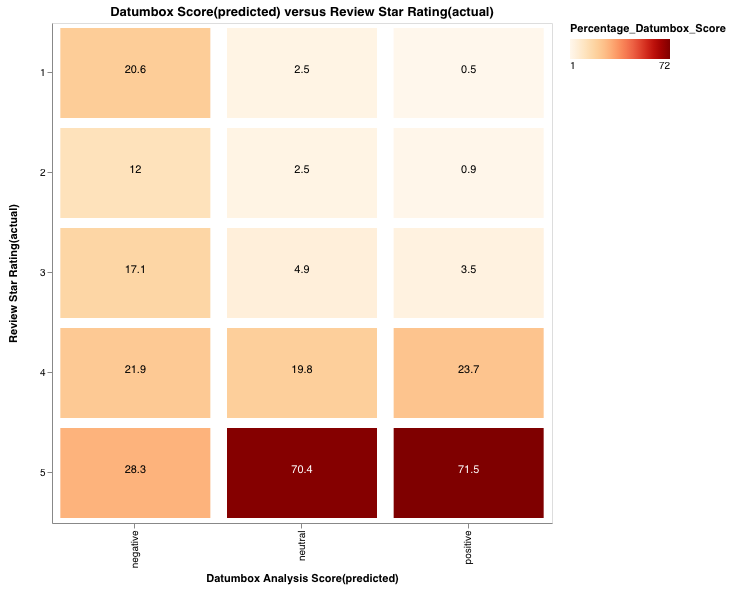

In [22]:
heatmap = alt.Chart(graphing).mark_rect().encode(
    alt.X('Datumbox_Score', type= "nominal", title = "Datumbox Analysis Score(predicted)"), 
    alt.Y('review_rating', type ='ordinal', title = "Review Star Rating(actual)"),
    alt.Color('Percentage_Datumbox_Score',type='quantitative',scale=alt.Scale(scheme='orangered')) 
).properties(title = "Datumbox Score(predicted) versus Review Star Rating(actual)", width=500, height=500) 
heatmap

text = alt.Chart(graphing).mark_text().encode(
    alt.X('Datumbox_Score', type= "nominal", title = "Datumbox Analysis Score(predicted)"), 
    alt.Y('review_rating', type ='ordinal', title = "Review Star Rating(actual)"),
    text = 'Percentage_Datumbox_Score',
    color = alt.condition(datum['Percentage_Datumbox_Score'] > 30,alt.value('white'),alt.value('black'))
)
heatmap + text



In [23]:
#analysis comments: 

#neutral or positive then its probably a 4 or 5 
#if negative could be almost anything 
#alot fewer negative reviews 
#normalizing within columns 
#because people are so much less likely to give negative. Although if negative review most likely negative
#when look at negative reviews 

#if positive score its most likely a 5 review star rating, but also 4 is reasonably likely 
#if negative score you cant as easily predict
#if try to go other way around 100 positive reviews only 10 negative reviews. Same amount of reviews 
#arent alot of negative reviews in te data set. Even though review score predicting sentiment if you have sentiment score for negative you cant easily predict which review star rating it will have 
#result of lack of negative reviews 
#alsmost always have negative sentiment when writing negative reviews. Any sentiment thats not negative will most likely positive. Negative sentiment could be negative review or could be minority of positive reviews that are written negatively
